Predictions for Best Picture of 2019 nominations. First of all, we will collect scraped data from Rotten Tomatoes website and afterwards building a classification model in order to predict which movie will be nominated for the Best Picture of 2019.

In [50]:
# Install headless browser to fasten webscraping
pip install selenium

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Import all nessasary libraries 
import pandas as pd
from bs4 import BeautifulSoup
import requests

Also, we will need GeckoDriver which is a link between Selenium and a web browser Firefox. I use Homebrew for Mac in order to install GeckoDriver.
If you do not have Homebrew installed on your Mac follow below steps:
1. Open Terminal on your Mac
2. Input the following and press Enter to run:
ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)" < /dev/null 2> /dev/null
3. Install Homebrew by inserting the following and press Enter:
brew install geckodriver
4. You might need to enter your Mac password
5. Tadaaa, we are done!

PS: Don't forget to dowload Firefox browser itself

In [3]:
from selenium import webdriver
from time import sleep

In [4]:
# Crete a driver named Firefox and Set nessesary URL

driver = webdriver.Firefox()
driver.get("https://www.rottentomatoes.com/browse/in-theaters/")

# Wait for 1 second and take needed information

sleep(1)
html = driver.page_source

In [5]:
# After we received html, we will use BeautifulSoup liabray to loacte nessesary elements and scrape their text

html = BeautifulSoup(html, "lxml")

#soup = BeautifulSoup(html.text, 'html.parser')

In [8]:
#Create a dataframe for multiple variables

oscar = pd.DataFrame(columns=['Title', 'Score', 'Release'])

In order to locate particular elements follow below steps:
1. Open Firefox browser and enter our URL
2. Right click on title or other nessesary variable and choose Inspect which opens HTML
3. Find title elements such as name and attributes

In [10]:
#Scrape the data into columns

for entry in html.find_all(name = 'div',attrs = {'class':"mb-movie"}):
    
    title = entry.find('h3', {'class':'movieTitle'}).text
    score = entry.find('span',{'class':'tMeterScore'}).text.strip('%')
    release = entry.find('p',{'class':'release-date'}).text
       
    
    oscar.loc[len(oscar)]=[title, score, duration]

oscar.head()

,Title,Score,Release
0,Star Wars: The Rise of Skywalker,55,In Theaters Oct 25
1,Jumanji: The Next Level,70,In Theaters Oct 25
2,Frozen II,77,In Theaters Oct 25
3,Cats,18,In Theaters Oct 25
4,Knives Out,96,In Theaters Oct 25


In [12]:
# 
oscar.Score.value_counts().sort_index()


18    2
23    2
25    2
39    2
40    2
44    4
47    2
51    2
55    2
68    2
69    2
70    4
73    4
77    2
79    2
81    2
83    4
91    2
92    2
94    4
95    2
96    2
97    4
99    2
Name: Score, dtype: int64

In [17]:
oscar['Nomination'] = oscar.Score.map({"0":0, "16":0,"18":0,"22":0,"23":0,"25":0,
                                       "39":0,"40":0,"44":0,"47":0,"51":0,"55":0,
                                       "65":0,"66":0,"68":0,"69":0,"70":0,"73":0,
                                       "77":0,"79":0, 
                                       "81":1, "82":1,"83":1,"85":1,"91":1, "92":1, "93":1,
                                       "94":1, "95":1, "97":1, "89":1,"99":1, 
                                       "96":1,"100":1})
oscar.head()

,Title,Score,Release,Nomination
0,Star Wars: The Rise of Skywalker,55,In Theaters Oct 25,0
1,Jumanji: The Next Level,70,In Theaters Oct 25,0
2,Frozen II,77,In Theaters Oct 25,0
3,Cats,18,In Theaters Oct 25,0
4,Knives Out,96,In Theaters Oct 25,1


In [31]:
#Fit logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear')

feature_cols = ['Score']
X = oscar[feature_cols]
y = oscar.Nomination

logreg.fit(X,y)
pred = logreg.predict(X)

Text(0, 0.5, 'Nomination')

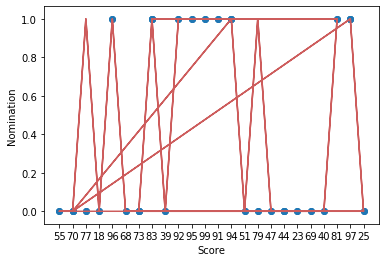

In [32]:
#Plot Logistic Regression

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(oscar.Score, oscar.Nomination)
plt.plot(oscar.Score, pred, color='indianred')
plt.xlabel('Score')
plt.ylabel('Nomination')

In [33]:
#Predicted Probabilities first 10 rows
logreg.predict_proba(X)[0:10]

array([[0.70932103, 0.29067897],
       [0.55494058, 0.44505942],
       [0.47684575, 0.52315425],
       [0.92745897, 0.07254103],
       [0.28026082, 0.71973918],
       [0.5769287 , 0.4230713 ],
       [0.52157813, 0.47842187],
       [0.4106552 , 0.5893448 ],
       [0.83317336, 0.16682664],
       [0.3177527 , 0.6822473 ]])

In [34]:
#Store probabilities

oscar['nomination_pred_prob'] = logreg.predict_proba(X)[:, 1]

Text(0, 0.5, 'Nomination')

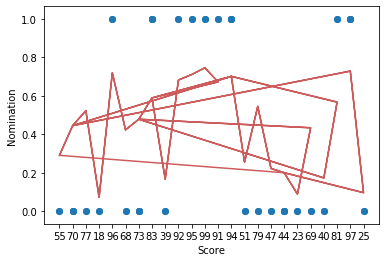

In [35]:
#Plot probabilities

plt.scatter(oscar.Score, oscar.Nomination)
plt.plot(oscar.Score, oscar.nomination_pred_prob, color='indianred')
plt.xlabel('Score')
plt.ylabel('Nomination')

In [36]:
#Predicted log odds for Score = 80
logodds = logreg.intercept_ + logreg.coef_[0] * 80
logodds

array([0.2269704])

In [37]:
import numpy as np
odds = np.exp(logodds)
odds

array([1.25479273])

In [38]:
#Predicted probability of a movie being Nominated for Oscar when score is 80%
prob = odds/(1 + odds)
prob

array([0.55650025])

## Advanced Classification Metrics

In [42]:
import pandas as pd
from sklearn import linear_model, model_selection, metrics

X = oscar[['Score']]
y = oscar['Nomination']

#Split the data on training and testing sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=46)

#Fit the model
logit_simple = linear_model.LogisticRegression(C=1e9, solver='liblinear').fit(X_train, y_train)

In [43]:
1. - y_train.mean()

0.6888888888888889

In [44]:
print(np.mean(y_test == logit_simple.predict(X_test)))

1.0


In [45]:
# Prediction Probability of being nominated

logit_pred_proba = logit_simple.predict_proba(X_test)[:,1]

In [46]:
# Confusion Matrix

metrics.confusion_matrix(y_true=y_test, y_pred=logit_pred_proba > .5)

array([[ 5,  0],
       [ 0, 10]])

As this example has only one independent variable, predictions result is not profound. However, the analyses demostrate useful webscraping tool and classification models using such python libraries as numpy,pandas, sklearn and BeautifulSoup. 